# Attention Is All You Need Boiled Down

## Introduction

Reccurent nueral architectures in NLP are awesome and everything, but they don't enable paralell computation and that's not so good from a computational efficiency perspective. That's why they are proposing the Transformer architecture, that models the dependency same as or even better than RNNs, and enable parallel computation.

<img src="https://1.cms.s81c.com/sites/default/files/2021-01-06/ICLH_Diagram_Batch_02_13B-RecurrentNeuralNetworks-WHITEBG.png" style="width: 70%; position: center;">

## Background

Some other architectures tried to minimize the sequential computation of RNN by using convolutions, then feeding their output to RNNs. But these architectures fail to model dependencies in parts of the sentences which are away from each other.

Other architectures also utilized self attention, but the Transform architecture is the first to used full self-attention to model relationships and produce outputs based only on the self attention without sequential modelling.

![self attention RNN](https://lilianweng.github.io/posts/2018-06-24-attention/encoder-decoder-attention.png)

## Model Architecture

Language models use encoder-decoder architecture, where encoder uses `x` input to produce continous `z` output, and the decoder uses `z` to produce `y = (y1, y2, y3, ...)` sequentially one step at a time, each time consuming the previously generated outputs.

## Encoder - Decoder 

![arch](https://i.stack.imgur.com/eAKQu.png)

## Attention

The attention used in the encoder-deocder block is Multi-Head Atention, consisting of multiple Scale Dot Product attention.

![mha](https://data-science-blog.com/wp-content/uploads/2022/01/mha_img_original.png)

## Simple Attention Layer 

In a encoder block, self attention is calculated from the output of the previous layer. Which means that `Q, K, V = X`.

Let's imagine having a batch of 1 sequence of embeddings.

In [5]:
import torch

In [6]:
X = torch.rand((16, 32))

In [7]:
Q, K, V = X, X, X

In [8]:
Q.shape, K.shape, V.shape

(torch.Size([16, 32]), torch.Size([16, 32]), torch.Size([16, 32]))

![sda](https://www.tutorialexample.com/wp-content/uploads/2020/10/Scaled-Dot-Product-Attention.png)

In [9]:
QKT = torch.nn.Softmax(dim=1)(torch.matmul(Q, K.T))
denom = Q.shape[1]**-2

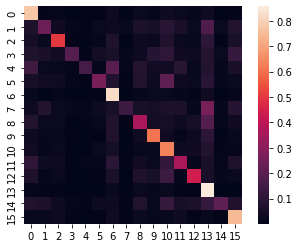

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(QKT, square=True);

The heatmap is symetric as it's supposed to be. Each cell is the dot product of one query vector with one key.

`Q -> (n, dq)`

`K -> (n, dk)`

`Q.KT -> (n, dq) x (dk, n) = (n, n)`

`q.kT -> (1, dq) x(dk, 1) = (1, 1)`

Text(0.5, 1.0, 'After')

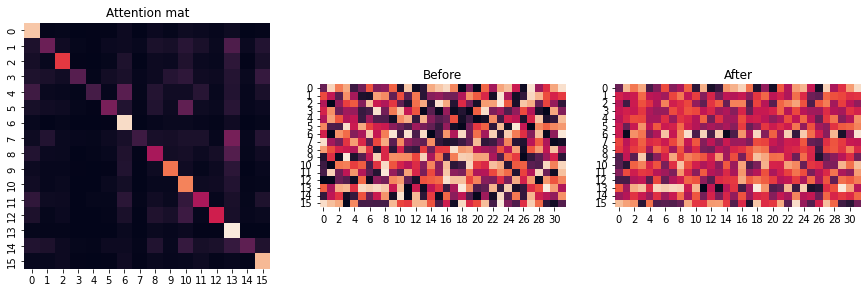

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Attention matrix
sns.heatmap(QKT, square=True, ax=axes[0], cbar=False);
axes[0].set_title('Attention mat')

# Before self attention
sns.heatmap(X, square=True, ax=axes[1], cbar=False);
axes[1].set_title('Before')

# After self attention
QKTV = torch.matmul(QKT, V)
sns.heatmap(QKTV, square=True, ax=axes[2], cbar=False);
axes[2].set_title('After')

In [12]:
def self_attention(X):
    Q, K, V = X, X, X
    QKT = torch.matmul(Q, K.T)
    softQKT = torch.nn.Softmax(dim=1)(QKT)
    return torch.matmul(softQKT, V)

In [19]:
def scaled_dot_prod_attention(X):
    Q, K, V = X, X, X
    QKT = torch.matmul(Q, K.T)
    scaleQKT = QKT/(Q.shape[1]**-2)
    softQKT = torch.nn.Softmax(dim=1)(scaleQKT)
    return torch.matmul(softQKT, V)

Text(0.5, 1.0, 'Scaled dot product attention')

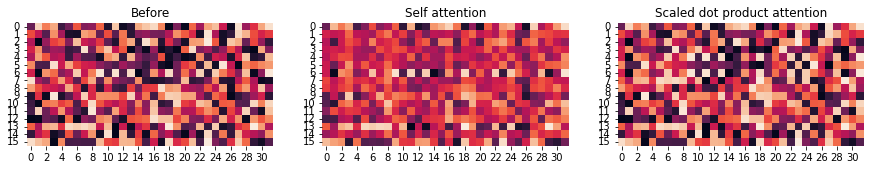

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Before self attention
sns.heatmap(X, square=True, ax=axes[0], cbar=False);
axes[0].set_title('Before')

# Attention matrix
sns.heatmap(self_attention(X), square=True, ax=axes[1], cbar=False);
axes[1].set_title('Self attention')

sns.heatmap(scaled_dot_prod_attention(X), square=True, ax=axes[2], cbar=False);
axes[2].set_title('Scaled dot product attention')

### Multi headed attention


1. Map X to (h) heads with Wq, Wk, Wv

In [21]:
h = 8
de = 32
dq = 32//h
dk = 32//h
dv = 32//h

X = torch.rand((4, 10, 32))

W_q = torch.nn.Linear(de, dq*h)
W_k = torch.nn.Linear(de, dk*h)
W_v = torch.nn.Linear(de, dv*h)

In [22]:
q, k, v = W_q(X), W_k(X), W_v(X)
q.shape, k.shape, v.shape

(torch.Size([4, 10, 32]), torch.Size([4, 10, 32]), torch.Size([4, 10, 32]))

In [23]:
# Split into different heads
bs = q.shape[0]
ln = q.shape[1]

q = q.view(bs, ln, h, dq)
k = k.view(bs, ln, h, dk)
v = v.view(bs, ln, h, dv)

q.shape, k.shape, v.shape

(torch.Size([4, 10, 8, 4]),
 torch.Size([4, 10, 8, 4]),
 torch.Size([4, 10, 8, 4]))

In [24]:
# Transpose ln and h for scaled dot product attention
q = q.transpose(1, 2)
k = k.transpose(1, 2)
v = v.transpose(1, 2)

q.shape, k.shape, v.shape

(torch.Size([4, 8, 10, 4]),
 torch.Size([4, 8, 10, 4]),
 torch.Size([4, 8, 10, 4]))

In [25]:
qkt = torch.einsum('bhqd, bhkd -> bhqk', q, k)

In [26]:
qkt.shape

torch.Size([4, 8, 10, 10])

In [27]:
qkt[0, 0, 0]

tensor([ 0.0825,  0.1882,  0.2977,  0.2708,  0.0831, -0.0555,  0.0917, -0.0943,
        -0.0938,  0.1633], grad_fn=<SelectBackward0>)

In [28]:
torch.matmul(q[0, 0, 0], k[0, 0, 0].T)

/tmp/ipykernel_57/508076111.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2981.)
  torch.matmul(q[0, 0, 0], k[0, 0, 0].T)


tensor(0.0825, grad_fn=<DotBackward0>)

In [29]:
# Sanity Check

(torch.matmul(q[0, 0], k[0, 0].T) == qkt[0, 0]).all()

tensor(True)

In [30]:
(torch.matmul(q[0, 1], k[0, 1].T) == qkt[0, 1]).all()

tensor(True)

In [31]:
def scaled_dot_prod_attention(q, k, v):
    qkt = torch.einsum('bhqd, bhkd -> bhqk', q, k)
    scale = qkt/(q.shape[-1]**-2)
    soft = torch.nn.Softmax(dim=-1)(scale)
    return torch.einsum('bhij, bhjk -> bhik', soft, v)

In [32]:
attn = scaled_dot_prod_attention(q, k, v)
attn.shape

torch.Size([4, 8, 10, 4])

In [33]:
q += attn

#### Add & Norm

In [34]:
layernorm = torch.nn.LayerNorm([h, ln, dq])
q = layernorm(q)

In [35]:
q = q.contiguous().view(bs, ln, -1)
q.shape

torch.Size([4, 10, 32])

Text(0.5, 1.0, 'After')

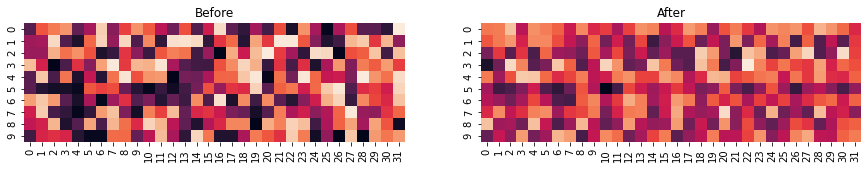

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

# Before attention
sns.heatmap(X[0], square=True, ax=axes[0], cbar=False);
axes[0].set_title('Before')

# After
sns.heatmap(q[0].detach().numpy(), square=True, ax=axes[1], cbar=False);
axes[1].set_title('After')

In [37]:
q.shape

torch.Size([4, 10, 32])

#### Positional Encodings

In [38]:
ln = 2048
de = 1024

X = torch.rand((4, ln, de))

In [39]:
pos, i = torch.where(X[0])
sin_enc = torch.sin(pos/(10000**(2*i/de)))
cos_enc = torch.cos(pos/(10000**(2*i/de)))
pos_enc = torch.where(i % 2 == 0, sin_enc, cos_enc).view(X.shape[1:])

<AxesSubplot:>

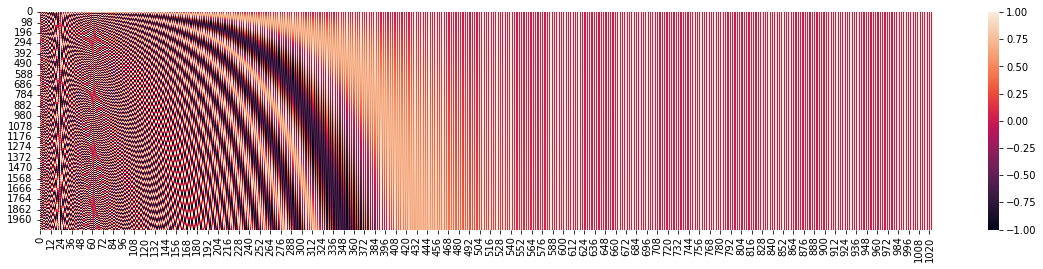

In [40]:
plt.figure(figsize=(20,4))
sns.heatmap(pos_enc)

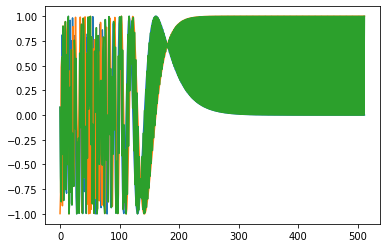

In [457]:
pos = 512
de = 512
i = torch.arange(0, de)
sin_enc = torch.sin(pos/(10000**(2*i/de)))
cos_enc = torch.cos(pos/(10000**(2*i/de)))
plt.plot(i, sin_enc);
plt.plot(i, cos_enc);
plt.plot(i, torch.where(i % 2 == 0, sin_enc, cos_enc));

In [458]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

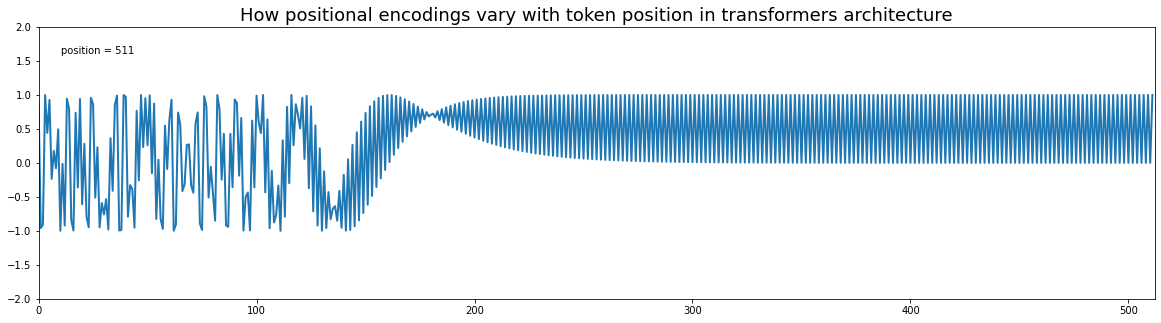

In [462]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(20, 5))
ax = plt.axes(xlim=(0, de), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)
pos_text = ax.text(0.02, 0.90, '', transform=ax.transAxes)
ax.set_title('How positional encodings vary with token position in transformers architecture',
             fontdict=dict(fontsize=18))
             
pos = 512
de = 512

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(pos):
    i = np.arange(0, de)
    sin_enc = np.sin(pos/(10000**(2*i/de)))
    cos_enc = np.cos(pos/(10000**(2*i/de)))
    y = np.where(i % 2 == 0, sin_enc, cos_enc)
    line.set_data(i, y)
    pos_text.set_text('position = %.1d' % pos)
    return line,


# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=pos, interval=20, blit=True)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()

In [30]:
X.shape, pos_enc.shape

(torch.Size([4, 2048, 1024]), torch.Size([2048, 1024]))

In [31]:
X_enc = X + pos_enc

Text(0.5, 1.0, 'After')

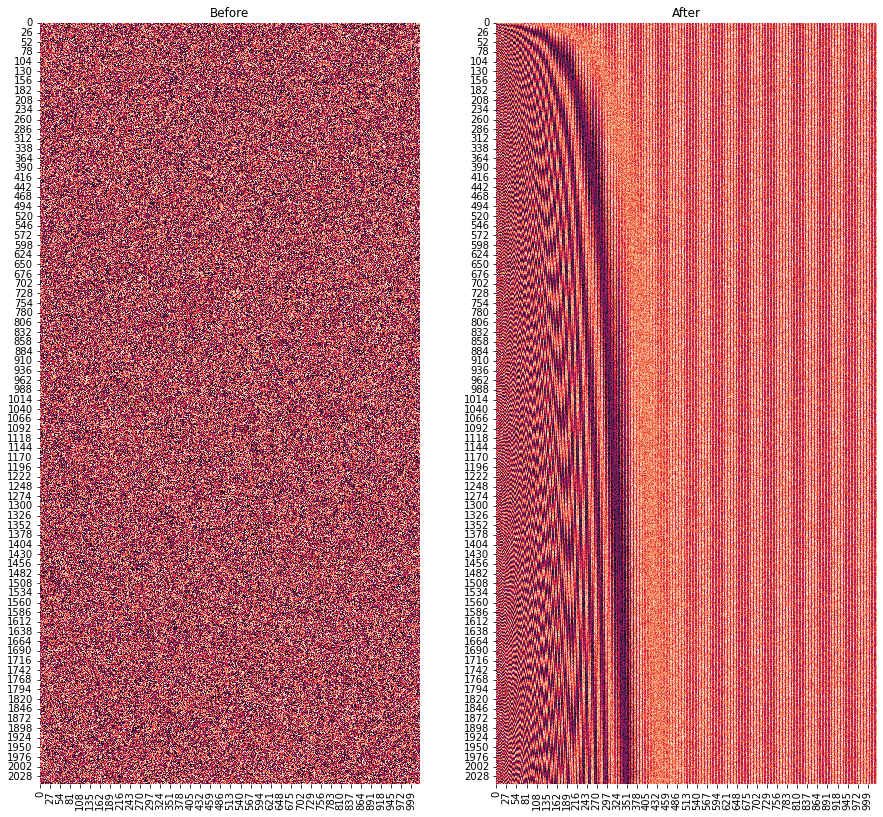

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 15))

# Before attention
sns.heatmap(X[0], square=True, ax=axes[0], cbar=False);
axes[0].set_title('Before')

# After
sns.heatmap(X_enc[0].detach().numpy(), square=True, ax=axes[1], cbar=False);
axes[1].set_title('After')

### Feed forward

In [26]:
X_enc.shape

torch.Size([4, 2048, 1024])

The mlp layer is supposed to take this input and output the same first two dimensions but with a new third dimension.

In [31]:
lin = torch.nn.Linear(1024, 2048)
lin(X_enc).shape

torch.Size([4, 2048, 2048])

In [32]:
lin2 = torch.nn.Linear(2048, 1024)
lin2(lin(X_enc)).shape

torch.Size([4, 2048, 1024])

### Full encoder

In [41]:
import torch

In [42]:
class MultiHeadedAttention(torch.nn.Module):
    def __init__(self, h, de, dq, dk, dv):
        super().__init__()
        self.h, self.de, self.dq, self.dk, self.dv = h, de, dq, dk, dv
        self.W_q = torch.nn.Linear(de, dq*h)
        self.W_k = torch.nn.Linear(de, dk*h)
        self.W_v = torch.nn.Linear(de, dv*h)
        self.W_o = torch.nn.Linear(h*dv, de) 
        self.layernorm = torch.nn.LayerNorm(de)
        self.dropout = torch.nn.Dropout(p=0.1)
        
    def scaled_dot_prod_attention(self, q, k, v):
        qkt = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        scale = qkt/(q.shape[-1]**-2)
        print('qkt/scale', scale.shape)
        soft = torch.nn.Softmax(dim=-1)(scale)
        return torch.einsum('bhij, bhjk -> bhik', soft, v)
        
    def forward(self, x):
        print('x', x.shape)
        
        q, k, v = self.W_q(x), self.W_k(x), self.W_v(x)
        
        print('Before splitting')
        print('q', q.shape)
        print('k', k.shape)
        print('v', v.shape)
        
        # Split into different heads
        bs = q.shape[0]
        ln = q.shape[1]

        q = q.view(bs, ln, self.h, self.dq)
        k = k.view(bs, ln, self.h, self.dk)
        v = v.view(bs, ln, self.h, self.dv)
        
        print('After splitting')
        print('q', q.shape)
        print('k', k.shape)
        print('v', v.shape)
        
        # Transpose ln and h for scaled dot product attention
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        print('After Transpose')
        print('q', q.shape)
        print('k', k.shape)
        print('v', v.shape)
        
        sdpa = self.scaled_dot_prod_attention(q, k, v)
        
        print('After scaled dot product')
        print('sdpa', sdpa.shape)
        
        # Linear projection of attention 
        sdpa = self.W_o(sdpa.view(bs, ln, -1))
        
        print('After linear projection')
        print('sdpa', sdpa.shape)
        
        
        # Add & Norm
        x = (sdpa + x).view(bs, ln, -1)
        x = self.layernorm(x)
        
        print('After add & norm')
        print('x', x.shape)
        
        x = self.dropout(x.contiguous().view(bs, ln, self.de))
        
        print('After concat')
        print('x', x.shape)
        
        return x

In [43]:
h, de, dq, dk, dv = (8, 512, 64, 64, 64)

mla = MultiHeadedAttention(h, de, dq, dk, dv)

x = torch.rand((8, 10, 512))

y = mla(x)

x torch.Size([8, 10, 512])
Before splitting
q torch.Size([8, 10, 512])
k torch.Size([8, 10, 512])
v torch.Size([8, 10, 512])
After splitting
q torch.Size([8, 10, 8, 64])
k torch.Size([8, 10, 8, 64])
v torch.Size([8, 10, 8, 64])
After Transpose
q torch.Size([8, 8, 10, 64])
k torch.Size([8, 8, 10, 64])
v torch.Size([8, 8, 10, 64])
qkt/scale torch.Size([8, 8, 10, 10])
After scaled dot product
sdpa torch.Size([8, 8, 10, 64])
After linear projection
sdpa torch.Size([8, 10, 512])
After add & norm
x torch.Size([8, 10, 512])
After concat
x torch.Size([8, 10, 512])


In [35]:
class MLP(torch.nn.Module):
    def __init__(self, de, in_d, debug=True):
        super().__init__()
        self.W1 = torch.nn.Linear(de, in_d)
        self.W2 = torch.nn.Linear(in_d, de)
        self.layernorm = torch.nn.LayerNorm(de)
        self.dropout = torch.nn.Dropout(p=0.1)
        self.debug = debug
        
    def forward(self, x):
        if self.debug:
            print('MLP')
            print('Before W')
            print('x', x.shape)
            
        x = x + self.W2(torch.nn.functional.relu(self.W1(x)))
        
        if self.debug:
            print('After W')
            print('x', x.shape)
            
        x = self.layernorm(x)
        x = self.dropout(x)
        return x

In [478]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_d, h, de, dq, dk, dv):
        super().__init__()
        self.mla = MultiHeadedAttention(h, de, dq, dk, dv)
        self.mlp = MLP(de, in_d)
        
    def forward(self, x):
        return self.mlp(self.mla(x))

In [479]:
in_d, h, de, dq, dk, dv = (2048, 8, 512, 64, 64, 64)

encoder_block = EncoderBlock(in_d, h, de, dq, dk, dv)

x = torch.rand((8, 10, 512))

y = encoder_block(x)

x torch.Size([8, 10, 512])
Before splitting
q torch.Size([8, 10, 512])
k torch.Size([8, 10, 512])
v torch.Size([8, 10, 512])
After splitting
q torch.Size([8, 10, 8, 64])
k torch.Size([8, 10, 8, 64])
v torch.Size([8, 10, 8, 64])
After Transpose
q torch.Size([8, 8, 10, 64])
k torch.Size([8, 8, 10, 64])
v torch.Size([8, 8, 10, 64])
qkt/scale torch.Size([8, 8, 10, 10])
After scaled dot product
sdpa torch.Size([8, 8, 10, 64])
After linear projection
sdpa torch.Size([8, 10, 512])
After add & norm
x torch.Size([8, 10, 512])
After concat
x torch.Size([8, 10, 512])
MLP
Before W
x torch.Size([8, 10, 512])
After W
x torch.Size([8, 10, 512])


## Decoder Block

### Understanding the last layer

This is the shape of the last output of a decoder layer (which is the same as encoders, so that's why I used it)

In [480]:
y.shape

torch.Size([8, 10, 512])

Now, we are supposed to use the embedding weight matrix to convert this (maxlen, dmodel) output to (N, maxlen)

Let's say we have a vocabulary of 100 words for example.

In [48]:
embedding = torch.nn.Embedding(100, 512)
embedding.weight.shape

torch.Size([100, 512])

I love einsum

In [49]:
presoftmax = torch.einsum('bmd, dn -> bmn', y, embedding.weight.T)
presoftmax.shape

torch.Size([8, 10, 100])

### Building a decoder block

In order to use the same `MultiHeadedAttention` class, we need to customize it to:
1. Use masks in the first part of decoder block attention
2. Take the encoder output as q and k

#### Visualize masking out

In [179]:
X = torch.rand((2, 8, 10, 32))

In [180]:
Q, K, V = X, X, X

In [181]:
Q.shape, K.shape, V.shape

(torch.Size([2, 8, 10, 32]),
 torch.Size([2, 8, 10, 32]),
 torch.Size([2, 8, 10, 32]))

![sda](https://www.tutorialexample.com/wp-content/uploads/2020/10/Scaled-Dot-Product-Attention.png)

In [232]:
QKT = torch.einsum('bhqj, bhkj -> bhqk', Q, K)

QKT = torch.nn.Softmax(dim=1)(QKT)
denom = Q.shape[1]**-2

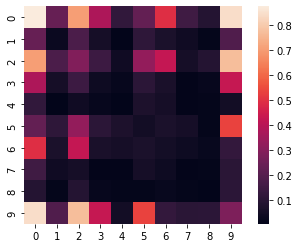

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(QKT[0, 0], square=True);

In [234]:
masks = torch.BoolTensor([[False, False, False, False, False, True, True, True, True, True],
                          [False, False, True, True, True, True, True, True, True, True]])

In [235]:
QKT = QKT.masked_fill(masks[:, None, None, :], -torch.inf)

In [236]:
QKT.shape

torch.Size([2, 8, 10, 10])

In [237]:
masks[:, None, None, :].shape

torch.Size([2, 1, 1, 10])

In [238]:
QKT.shape

torch.Size([2, 8, 10, 10])

In [239]:
QKT = torch.nn.Softmax(dim=-1)(QKT)

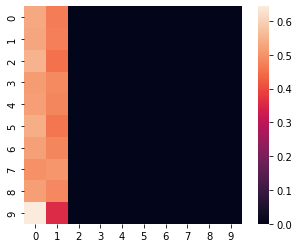

In [242]:
sns.heatmap(QKT[1, 3], square=True);

In [28]:
import torch

In [36]:
class MultiHeadedAttention(torch.nn.Module):
    def __init__(self, h, de, dq, dk, dv, debug=True):
        super().__init__()
        self.h, self.de, self.dq, self.dk, self.dv, self.debug = h, de, dq, dk, dv, debug
        self.W_q = torch.nn.Linear(de, dq*h)
        self.W_k = torch.nn.Linear(de, dk*h)
        self.W_v = torch.nn.Linear(de, dv*h)
        self.W_o = torch.nn.Linear(h*dv, de) 
        self.layernorm = torch.nn.LayerNorm(de)
        self.dropout = torch.nn.Dropout(p=0.1)
        
    def scaled_dot_prod_attention(self, q, k, v, masks=None):
        qkt = torch.einsum('bhqd, bhkd -> bhqk', q, k)
        scale = qkt/(q.shape[-1]**-2)
        
        if self.debug:
            print('qkt/scale', scale.shape)
        
        if masks is not None:
            if self.debug:
                print('masks', masks[:, None, None, :].shape)
            
            scale = scale.masked_fill(masks[:, None, None, :], -torch.inf)
        
        soft = torch.nn.Softmax(dim=-1)(scale)
        return torch.einsum('bhij, bhjk -> bhik', soft, v)
        
    def forward(self, x, encoder_output=None, masks=None):
        if self.debug:
            print('x', x.shape)
        
        if encoder_output is not None:
            # I don't know if the encoder_output should be linearly transformed
            # So I need to test this later on 
            q, k, v = self.W_q(x), self.W_k(encoder_output), self.W_v(encoder_output)
        else:
            q, k, v = self.W_q(x), self.W_k(x), self.W_v(x)
        
        if self.debug:
            print('Before splitting')
            print('q', q.shape)
            print('k', k.shape)
            print('v', v.shape)
        
        # Split into different heads
        bs = q.shape[0]
        ln_q = q.shape[1]
        ln_k = k.shape[1]
        ln_v = v.shape[1]

        q = q.view(bs, ln_q, self.h, self.dq)
        k = k.view(bs, ln_k, self.h, self.dk)
        v = v.view(bs, ln_v, self.h, self.dv)
        
        if self.debug:
            print('After splitting')
            print('q', q.shape)
            print('k', k.shape)
            print('v', v.shape)
        
        # Transpose ln and h for scaled dot product attention
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        if self.debug:
            print('After Transpose')
            print('q', q.shape)
            print('k', k.shape)
            print('v', v.shape)
        
        sdpa = self.scaled_dot_prod_attention(q, k, v, masks)
        
        if self.debug:
            print('After scaled dot product')
            print('sdpa', sdpa.shape)
        
        # Linear projection of attention 
        sdpa = self.W_o(sdpa.view(bs, ln_q, -1))
        
        if self.debug:
            print('After linear projection')
            print('sdpa', sdpa.shape)
        
        # Add & Norm
        x = (sdpa + x).view(bs, ln_q, -1)
        x = self.layernorm(x)
        
        if self.debug:
            print('After add & norm')
            print('x', x.shape)
        
        x = self.dropout(x.contiguous().view(bs, ln_q, self.de))
        
        if self.debug:
            print('After concat')
            print('x', x.shape)

        return x

In [37]:
class EncoderBlock(torch.nn.Module):
    def __init__(self, in_d, h, de, dq, dk, dv, debug=True):
        super().__init__()
        self.mla = MultiHeadedAttention(h, de, dq, dk, dv, debug)
        self.mlp = MLP(de, in_d, debug)
        
    def forward(self, x):
        return self.mlp(self.mla(x))

In [38]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, in_d, h, de, dq, dk, dv, debug=True):
        super().__init__()
        self.mla1 = MultiHeadedAttention(h, de, dq, dk, dv, debug)
        self.mla2 = MultiHeadedAttention(h, de, dq, dk, dv, debug)
        self.mlp = MLP(de, in_d, debug)
        
    def forward(self, x, encoder_output, masks):
        x = self.mla1(x, masks=masks)
        x = self.mla2(x, encoder_output=encoder_output)
        x = self.mlp(x)
        return x

In [39]:
torch.BoolTensor([[j <= i for j in range(10)] for i in range(8)])

tensor([[ True, False, False, False, False, False, False, False, False, False],
        [ True,  True, False, False, False, False, False, False, False, False],
        [ True,  True,  True, False, False, False, False, False, False, False],
        [ True,  True,  True,  True, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True, False, False]])

In [40]:
in_d, h, de, dq, dk, dv = (2048, 8, 512, 64, 64, 64)

masks = torch.BoolTensor([[j <= i for j in range(10)] for i in range(8)])

encoder_block = EncoderBlock(in_d, h, de, dq, dk, dv)
decoder_block = DecoderBlock(in_d, h, de, dq, dk, dv)


x = torch.rand((8, 10, 512))

encoder_output = encoder_block(x)
y = decoder_block(x, encoder_output, masks)

x torch.Size([8, 10, 512])
Before splitting
q torch.Size([8, 10, 512])
k torch.Size([8, 10, 512])
v torch.Size([8, 10, 512])
After splitting
q torch.Size([8, 10, 8, 64])
k torch.Size([8, 10, 8, 64])
v torch.Size([8, 10, 8, 64])
After Transpose
q torch.Size([8, 8, 10, 64])
k torch.Size([8, 8, 10, 64])
v torch.Size([8, 8, 10, 64])
qkt/scale torch.Size([8, 8, 10, 10])
After scaled dot product
sdpa torch.Size([8, 8, 10, 64])
After linear projection
sdpa torch.Size([8, 10, 512])
After add & norm
x torch.Size([8, 10, 512])
After concat
x torch.Size([8, 10, 512])
MLP
Before W
x torch.Size([8, 10, 512])
After W
x torch.Size([8, 10, 512])
x torch.Size([8, 10, 512])
Before splitting
q torch.Size([8, 10, 512])
k torch.Size([8, 10, 512])
v torch.Size([8, 10, 512])
After splitting
q torch.Size([8, 10, 8, 64])
k torch.Size([8, 10, 8, 64])
v torch.Size([8, 10, 8, 64])
After Transpose
q torch.Size([8, 8, 10, 64])
k torch.Size([8, 8, 10, 64])
v torch.Size([8, 8, 10, 64])
qkt/scale torch.Size([8, 8, 10,

In [41]:
y.shape

torch.Size([8, 10, 512])

#### This means that I have succesfully implemented the building blocks of the transformer, now I only need to package it all into one module.

Since I have implemented the encoder and decoder building blocks, the transformer still needs the following defined individually:
1. Input embeddings
2. Output embeddings
3. Positional encodings
4. Final linear layer + Softmax

In [42]:
class Transformer(torch.nn.Module):
    def __init__(self, n_vocab_inp, dmodel=512, dmiddle=2048, dq=64, dk=64, dv=64, h=8, n_encoders=6, n_decoders=6, debug=True):
        super().__init__()
        
        self.dmodel = dmodel
        self.input_embeddings = torch.nn.Embedding(num_embeddings=n_vocab_inp, embedding_dim=dmodel)
        self.encoder_blocks = torch.nn.ModuleList([EncoderBlock(dmiddle, h, dmodel, dq, dk, dv, debug) for _ in range(n_encoders)])
        self.decoder_blocks = torch.nn.ModuleList([DecoderBlock(dmiddle, h, dmodel, dq, dk, dv, debug) for _ in range(n_decoders)])
        
    def forward(self, x, y, masks):
        x = self.input_embeddings(x)
        x = self.add_positional_encodings(x)
        for encoder in self.encoder_blocks:
            x = encoder(x)
        
        
        y = self.input_embeddings(y)
        y = self.add_positional_encodings(y)
        for decoder in self.decoder_blocks:
            y = decoder(y, x, masks)
            
        presoftmax = self.final_linear(y)
        final = torch.nn.functional.softmax(presoftmax, dim=-1)
             
        return final
    
    def add_positional_encodings(self, x):
        pos, i = torch.where(x[0])
        sin_enc = torch.sin(pos/(10000**(2*i/self.dmodel)))
        cos_enc = torch.cos(pos/(10000**(2*i/self.dmodel)))
        pos_enc = torch.where(i % 2 == 0, sin_enc, cos_enc).view(x.shape[1:])
        return x + pos_enc
    
    def final_linear(self, y):
        return torch.einsum('bmd, dn -> bmn', y, self.input_embeddings.weight.T)
    

In [169]:
x = torch.LongTensor([[1, 2, 3, 4, 5, 6]])
y = torch.LongTensor([[1, 2, 3, 4, 5, 6]])
masks = torch.BoolTensor([[False, False, False, False, False, True]])

transformer = Transformer(10)
transformer(x, y, masks)

x torch.Size([1, 6, 512])
Before splitting
q torch.Size([1, 6, 512])
k torch.Size([1, 6, 512])
v torch.Size([1, 6, 512])
After splitting
q torch.Size([1, 6, 8, 64])
k torch.Size([1, 6, 8, 64])
v torch.Size([1, 6, 8, 64])
After Transpose
q torch.Size([1, 8, 6, 64])
k torch.Size([1, 8, 6, 64])
v torch.Size([1, 8, 6, 64])
qkt/scale torch.Size([1, 8, 6, 6])
After scaled dot product
sdpa torch.Size([1, 8, 6, 64])
After linear projection
sdpa torch.Size([1, 6, 512])
After add & norm
x torch.Size([1, 6, 512])
After concat
x torch.Size([1, 6, 512])
MLP
Before W
x torch.Size([1, 6, 512])
After W
x torch.Size([1, 6, 512])
x torch.Size([1, 6, 512])
Before splitting
q torch.Size([1, 6, 512])
k torch.Size([1, 6, 512])
v torch.Size([1, 6, 512])
After splitting
q torch.Size([1, 6, 8, 64])
k torch.Size([1, 6, 8, 64])
v torch.Size([1, 6, 8, 64])
After Transpose
q torch.Size([1, 8, 6, 64])
k torch.Size([1, 8, 6, 64])
v torch.Size([1, 8, 6, 64])
qkt/scale torch.Size([1, 8, 6, 6])
After scaled dot product

tensor([[[4.9886e-43, 1.0000e+00, 3.9206e-36, 5.7145e-42, 1.3433e-25,
          0.0000e+00, 6.2132e-30, 0.0000e+00, 2.4392e-38, 9.5266e-41],
         [0.0000e+00, 8.9206e-38, 1.0000e+00, 1.3781e-40, 9.4739e-35,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8327e-39, 0.0000e+00],
         [0.0000e+00, 1.5908e-21, 7.2001e-10, 1.0000e+00, 1.1882e-23,
          5.1316e-23, 2.7892e-13, 2.0039e-43, 1.2003e-17, 8.0796e-22],
         [5.0424e-29, 4.2039e-45, 4.8955e-34, 9.8091e-44, 1.0000e+00,
          2.3402e-42, 2.0515e-33, 2.0155e-40, 0.0000e+00, 6.7429e-35],
         [0.0000e+00, 9.7216e-41, 1.6019e-33, 0.0000e+00, 3.8531e-40,
          1.0000e+00, 1.2817e-40, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [3.3749e-28, 4.6451e-25, 1.6421e-34, 7.1016e-34, 3.3755e-33,
          6.9489e-26, 1.0000e+00, 6.3739e-25, 1.2394e-33, 5.7322e-22]]],
       grad_fn=<SoftmaxBackward0>)

### Download dataset

In [76]:
from datasets import load_dataset_builder

In [2]:
ds_builder = load_dataset_builder("wmt14", 'de-en', data_dir='data')

Using custom data configuration de-en-data_dir=data


In [3]:
print(ds_builder.info.description)

Translate dataset based on the data from statmt.org.

Versions exists for the different years using a combination of multiple data
sources. The base `wmt_translate` allows you to create your own config to choose
your own data/language pair by creating a custom `datasets.translate.wmt.WmtConfig`.

```
config = datasets.wmt.WmtConfig(
    version="0.0.1",
    language_pair=("fr", "de"),
    subsets={
        datasets.Split.TRAIN: ["commoncrawl_frde"],
        datasets.Split.VALIDATION: ["euelections_dev2019"],
    },
)
builder = datasets.builder("wmt_translate", config=config)
```




In [4]:
ds_builder.info.features

{'translation': Translation(languages=['de', 'en'], id=None)}

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset("wmt14", "de-en", split=["train", "test"], cache_dir="data")

Reusing dataset wmt14 (data/wmt14/de-en/1.0.0/6aa64c5c4f2c1c217718c6d6266aad92d1229e761c57379c53752b8c0e55c93b)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

[Dataset({
     features: ['translation'],
     num_rows: 4508785
 }),
 Dataset({
     features: ['translation'],
     num_rows: 3003
 })]

In [4]:
from tokenizers import Tokenizer
from tokenizers.models import BPE

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))

In [5]:
from tokenizers import normalizers

tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.NFD(), 
        normalizers.Lowercase(), 
        normalizers.StripAccents()
    ]
)

In [6]:
from tokenizers.trainers import BpeTrainer

trainer = BpeTrainer(special_tokens=["[PAD]", "[SOS]", "[EOS]", "[UNK]"])

In [7]:
from tokenizers.pre_tokenizers import Whitespace

tokenizer.pre_tokenizer = Whitespace()

In [8]:
from itertools import chain

list(chain.from_iterable(map(lambda x: x.values(), dataset[0][0:10]['translation'])))

['Wiederaufnahme der Sitzungsperiode',
 'Resumption of the session',
 'Ich erkläre die am Freitag, dem 17. Dezember unterbrochene Sitzungsperiode des Europäischen Parlaments für wiederaufgenommen, wünsche Ihnen nochmals alles Gute zum Jahreswechsel und hoffe, daß Sie schöne Ferien hatten.',
 'I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.',
 'Wie Sie feststellen konnten, ist der gefürchtete "Millenium-Bug " nicht eingetreten. Doch sind Bürger einiger unserer Mitgliedstaaten Opfer von schrecklichen Naturkatastrophen geworden.',
 "Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.",
 'Im Parlament besteht der Wunsch nach einer Aussprache im Verlauf dieser Sitzungsperiode in den nächsten Tage

In [9]:
batch_size = 1000
def batch_iterator():
    for i in range(2):
        for j in range(0, len(dataset[i]), batch_size):
            yield list(
                chain.from_iterable(
                    map(lambda x: x.values(),
                        dataset[0][0:batch_size]['translation'])
                )
            )

In [10]:
# next(batch_iterator())

In [11]:
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

In [12]:
from tokenizers.processors import TemplateProcessing
# tokenizer.post_processor = TemplateProcessing(
#     single="[SOS] $A [EOS]",
#     special_tokens=[
#         ("[SOS]", tokenizer.token_to_id("[SOS]")),
#         ("[EOS]", tokenizer.token_to_id("[EOS]")),
#     ],
# )

In [111]:
tokenizer.save("data/tokenizer-wmt14.json")

In [13]:
tokenizer = tokenizer.from_file("data/tokenizer-wmt14.json")

The input tokens for the encoder should neither have [SOS] or [EOS]

In [17]:
output = tokenizer.encode(dataset[0][0]['translation']['en'])
print(output.tokens[1:-1])
print(output.ids[1:-1])

['resumption', 'of', 'the', 'session']
[11377, 85, 70, 2367]


The input tokens for the decoder should only have [SOS]

In [18]:
output = tokenizer.encode(dataset[0][0]['translation']['de'])
print(output.tokens[:-1])
print(output.ids[:-1])

['[SOS]', 'wiederaufnahme', 'der', 'sitzungsperiode']
[1, 6261, 77, 4259]


The output labels for the decoder should only have [EOS]

In [19]:
output = tokenizer.encode(dataset[0][0]['translation']['de'])
print(output.tokens[1:])
print(output.ids[1:])

['wiederaufnahme', 'der', 'sitzungsperiode', '[EOS]']
[6261, 77, 4259, 2]


## What is each batch supposed to contain?
1. encoder input ids
2. decoder input ids
3. decoder input masks
4. target ids
5. target masks

### encoder input ids

It should be replicated as the length of of the decoder input ids without the [SOS] token, and each tensor shouldn't contain neither [SOS] nor [EOS].

In [14]:
import torch

In [15]:
encoder_input = tokenizer.encode(dataset[0][0]['translation']['en'])
decoder_input = tokenizer.encode(dataset[0][0]['translation']['de'])

encoder_input.tokens

['[SOS]', 'resumption', 'of', 'the', 'session', '[EOS]']

In [16]:
encoder_input_ids = torch.tensor([encoder_input.ids for _ in range(len(decoder_input)-1)])[:, 1:-1]

encoder_input_ids

tensor([[11377,    85,    70,  2367],
        [11377,    85,    70,  2367],
        [11377,    85,    70,  2367],
        [11377,    85,    70,  2367]])

### deocder input ids

The decoder input ids tensor should be replicates as the length of the decoder input ids without [EOS] token, and each tensor should only contain [SOS] token.

In [17]:
decoder_input_ids = torch.tensor([decoder_input.ids for _ in range(len(decoder_input)-1)])[:, :-1]

decoder_input_ids

tensor([[   1, 6261,   77, 4259],
        [   1, 6261,   77, 4259],
        [   1, 6261,   77, 4259],
        [   1, 6261,   77, 4259]])

### decoder input masks

If we suppose that we have n rows and m columns, then for each row i the mask should be from i+1:m+1.

In [18]:
n, m = decoder_input_ids.shape

decoder_input_masks = torch.zeros_like(decoder_input_ids)

for i in range(n):
    decoder_input_masks[i, i+1:] = 1
    
decoder_input_masks

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

Actually there is a function in torch that does that same thing.

In [19]:
decoder_input_masks = torch.ones_like(decoder_input_ids)

decoder_input_masks = torch.triu(decoder_input_masks, diagonal=1)

decoder_input_masks

tensor([[0, 1, 1, 1],
        [0, 0, 1, 1],
        [0, 0, 0, 1],
        [0, 0, 0, 0]])

### target ids

The target ids tensor should be replicates as the length of the decoder input ids without [SOS] token, and each tensor should only contain [EOS] token.

In [20]:
target_ids = torch.tensor([decoder_input.ids for _ in range(len(decoder_input)-1)])[:, 1:]

target_ids

tensor([[6261,   77, 4259,    2],
        [6261,   77, 4259,    2],
        [6261,   77, 4259,    2],
        [6261,   77, 4259,    2]])

### target masks

If we suppose that we have n rows and m columns, then for each row i the mask should be from i+1:m+1.

In [21]:
target_masks = torch.ones_like(target_ids)

target_masks = torch.tril(target_masks)

target_masks

tensor([[1, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1]])

#### Now what remains is a dataset that gets these items for each row

### Creating Dataset and Dataloader

In [46]:
from torch.utils.data import Dataset, DataLoader

class TransformerDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tokenized_input = tokenizer.encode(self.data[idx]['translation']['en'])
        tokenized_output = tokenizer.encode(self.data[idx]['translation']['de'])

        encoder_input_ids = torch.tensor([tokenized_input.ids for _ in range(len(tokenized_output.ids)-1)])[:, 1:-1]
        
        tokenized_output_ids = torch.tensor([tokenized_output.ids for _ in range(len(tokenized_output.ids)-1)])
        
        decoder_input_ids = tokenized_output_ids[:, :-1]
        decoder_input_masks = self.get_decoder_masks(decoder_input_ids)
        
        
        target_ids = tokenized_output_ids[:, 1:]
        target_masks = self.get_target_masks(target_ids)
        
        return encoder_input_ids, decoder_input_ids, target_ids, decoder_input_masks, target_masks
        

    def get_decoder_masks(self, ids):
        masks = torch.ones_like(ids)
        return torch.triu(masks, diagonal=1)
    
    def get_target_masks(self, ids):
        masks = torch.ones_like(ids)
        return torch.tril(masks)

In [59]:
TrainDataset = TransformerDataset(dataset[0], tokenizer)

In [60]:
encoder_input_ids, decoder_input_ids, target_ids, decoder_input_masks, target_masks = TrainDataset[1]

In [61]:
encoder_input_ids.shape, decoder_input_ids.shape, decoder_input_masks.shape, target_ids.shape, target_masks.shape

(torch.Size([35, 40]),
 torch.Size([35, 35]),
 torch.Size([35, 35]),
 torch.Size([35, 35]),
 torch.Size([35, 35]))

#### Now it remains to make a dataloader that collates the output of each row together to form a batch. 

#### Therefore we need to make a collate function.

Let's get two rows to see how that goes.

In [62]:
r1 = TrainDataset[0]
r2 = TrainDataset[1]

In [63]:
for i in range(len(r1)):
    print(r1[i].shape, r2[i].shape)

torch.Size([4, 4]) torch.Size([35, 40])
torch.Size([4, 4]) torch.Size([35, 35])
torch.Size([4, 4]) torch.Size([35, 35])
torch.Size([4, 4]) torch.Size([35, 35])
torch.Size([4, 4]) torch.Size([35, 35])


Since I'll stack each of these pairs, then they need to be padded with the longest sequence lenght.

In [64]:
r1[0]

tensor([[11377,    85,    70,  2367],
        [11377,    85,    70,  2367],
        [11377,    85,    70,  2367],
        [11377,    85,    70,  2367]])

In [65]:
import torch.nn.functional as F

F.pad(r1[0], (0, 4), "constant", 1)

tensor([[11377,    85,    70,  2367,     1,     1,     1,     1],
        [11377,    85,    70,  2367,     1,     1,     1,     1],
        [11377,    85,    70,  2367,     1,     1,     1,     1],
        [11377,    85,    70,  2367,     1,     1,     1,     1]])

So for each batch I need to find the max length of sequence then pad with the difference between the current tensor length and the maximum length, then stack all of them.

In [66]:
max_seq_len = [max([t.shape[1] for t in ts]) for ts in zip(r1, r2)]
max_seq_len

[40, 35, 35, 35, 35]

In [67]:
F.pad(r1[0], (0, max_seq_len[0] - r1[0].shape[1]), "constant", 3).shape

torch.Size([4, 40])

In [68]:
padded_r1 = [F.pad(r1[i], (0, max_seq_len[i] - r1[i].shape[1]), "constant", 0) for i in range(len(r1))]
padded_r2 = [F.pad(r2[i], (0, max_seq_len[i] - r2[i].shape[1]), "constant", 0) for i in range(len(r2))]

b = [torch.concat(ts, dim=0) for ts in zip(padded_r1, padded_r2)]

In [69]:
b[2]

tensor([[6261,   77, 4259,  ...,    0,    0,    0],
        [6261,   77, 4259,  ...,    0,    0,    0],
        [6261,   77, 4259,  ...,    0,    0,    0],
        ...,
        [  71, 7494,   92,  ..., 1962,   12,    2],
        [  71, 7494,   92,  ..., 1962,   12,    2],
        [  71, 7494,   92,  ..., 1962,   12,    2]])

Finally let's define the collate_fn and create a dataloder

In [70]:
def pad_row(r, max_seq_len):
    "Pads each row from Dataset __getitem__ to maximum sequence length in the current batch"
    return [F.pad(r[i], (0, max_seq_len[i] - r[i].shape[1]), "constant", 0) for i in range(len(r))]

In [71]:
def collate_fn(batch):
    "Collates multiples tuples into one tensor by padding their sequence length and concatenating them"
    max_seq_len = [max([t.shape[1] for t in ts]) for ts in zip(*batch)]
    padded_batch = [pad_row(r, max_seq_len) for r in batch]
    return [torch.concat(ts, dim=0) for ts in zip(*padded_batch)]

In [72]:
b = collate_fn([r1, r1, r2])

In [73]:
[b[i].shape for i in range(len(b))]

[torch.Size([43, 40]),
 torch.Size([43, 35]),
 torch.Size([43, 35]),
 torch.Size([43, 35]),
 torch.Size([43, 35])]

In [74]:
dataloader = DataLoader(TrainDataset, batch_size=2, collate_fn=collate_fn)

It is working.

In [75]:
next(iter(dataloader))

[tensor([[11377,    85,    70,  ...,     0,     0,     0],
         [11377,    85,    70,  ...,     0,     0,     0],
         [11377,    85,    70,  ...,     0,     0,     0],
         ...,
         [   37, 10354, 11376,  ..., 10878,   874,    12],
         [   37, 10354, 11376,  ..., 10878,   874,    12],
         [   37, 10354, 11376,  ..., 10878,   874,    12]]),
 tensor([[   1, 6261,   77,  ...,    0,    0,    0],
         [   1, 6261,   77,  ...,    0,    0,    0],
         [   1, 6261,   77,  ...,    0,    0,    0],
         ...,
         [   1,   71, 7494,  ..., 8859, 1962,   12],
         [   1,   71, 7494,  ..., 8859, 1962,   12],
         [   1,   71, 7494,  ..., 8859, 1962,   12]]),
 tensor([[6261,   77, 4259,  ...,    0,    0,    0],
         [6261,   77, 4259,  ...,    0,    0,    0],
         [6261,   77, 4259,  ...,    0,    0,    0],
         ...,
         [  71, 7494,   92,  ..., 1962,   12,    2],
         [  71, 7494,   92,  ..., 1962,   12,    2],
         [  71, 7

In [76]:
b = next(iter(dataloader))

Let's test this with a transformer.

In [77]:
tokenizer.get_vocab_size()

12307

In [78]:
b[-2], b[-2].shape

(tensor([[0, 1, 1,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 1, 1],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]]),
 torch.Size([39, 35]))

In [79]:
transformer = Transformer(tokenizer.get_vocab_size(), debug=True)
y = transformer(b[0], b[1], b[-2])

x torch.Size([39, 40, 512])
Before splitting
q torch.Size([39, 40, 512])
k torch.Size([39, 40, 512])
v torch.Size([39, 40, 512])
After splitting
q torch.Size([39, 40, 8, 64])
k torch.Size([39, 40, 8, 64])
v torch.Size([39, 40, 8, 64])
After Transpose
q torch.Size([39, 8, 40, 64])
k torch.Size([39, 8, 40, 64])
v torch.Size([39, 8, 40, 64])
qkt/scale torch.Size([39, 8, 40, 40])
After scaled dot product
sdpa torch.Size([39, 8, 40, 64])
After linear projection
sdpa torch.Size([39, 40, 512])
After add & norm
x torch.Size([39, 40, 512])
After concat
x torch.Size([39, 40, 512])
MLP
Before W
x torch.Size([39, 40, 512])
After W
x torch.Size([39, 40, 512])
x torch.Size([39, 40, 512])
Before splitting
q torch.Size([39, 40, 512])
k torch.Size([39, 40, 512])
v torch.Size([39, 40, 512])
After splitting
q torch.Size([39, 40, 8, 64])
k torch.Size([39, 40, 8, 64])
v torch.Size([39, 40, 8, 64])
After Transpose
q torch.Size([39, 8, 40, 64])
k torch.Size([39, 8, 40, 64])
v torch.Size([39, 8, 40, 64])
qkt/

Mask out outputs that we aren't supposed to predict

In [80]:
b[-2].shape

torch.Size([39, 35])

In [81]:
# out = y.masked_fill(b[-2].unsqueeze(-1), 0)

In [82]:
out = y

In [83]:
y[0][1]

tensor([0.0000e+00, 1.4906e-27, 6.3943e-32,  ..., 0.0000e+00, 4.1886e-36,
        1.0566e-20], grad_fn=<SelectBackward0>)

In [84]:
out[0][0]

tensor([0.0000e+00, 8.1007e-01, 4.7359e-27,  ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00], grad_fn=<SelectBackward0>)

Flatten the output for easier loss calculation

In [450]:
out = out.view(-1, tokenizer.get_vocab_size())
out.shape

torch.Size([1365, 12307])

Mask out the target to avoid calculating the loss for non-predicted targets

In [355]:
targ = b[2].masked_fill(b[-1], 0)

In [451]:
targ = b[2].flatten()

In [452]:
targ = targ.flatten()
targ.shape

torch.Size([1365])

In [453]:
out = torch.nn.Softmax(dim=-1)(out)

In [410]:
out.argmax(dim=-1)

tensor([10073,  9756, 11462,  7961,  1228,  6261,  2440,  4259, 11777,  6261,
           77,  9990,     1,  6261,    77,  4259])

In [411]:
targ

tensor([6261,   77, 4259,    2, 6261,   77, 4259,    2, 6261,   77, 4259,    2,
        6261,   77, 4259,    2])

In [412]:
b[-1].flatten()

tensor([1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1])

In [455]:
loss = torch.nn.CrossEntropyLoss()
loss(out, targ)

tensor(9.4179, grad_fn=<NllLossBackward0>)

In [454]:
loss = torch.nn.CrossEntropyLoss(reduction='none')
(loss(out, targ)*b[-1].flatten()).mean()

tensor(4.4157, grad_fn=<MeanBackward0>)

## Basic Training Loop

In [90]:
decoder_input_masks.bool()

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [False, False,  True,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ..., False,  True,  True],
        [False, False, False,  ..., False, False,  True],
        [False, False, False,  ..., False, False, False]])

In [95]:
def train_one_epoch(epoch_index, model, optimizer, loss_fn, training_loader):
    running_loss = 0.
    last_loss = 0.
    
    for i, data in enumerate(training_loader):
        encoder_input_ids, decoder_input_ids, target_ids, decoder_input_masks, target_masks = data
        optimizer.zero_grad()
        outputs = model(encoder_input_ids.to('cuda'), decoder_input_ids.to('cuda'), decoder_input_masks.to('cuda').bool())
        
        outputs = torch.nn.Softmax(dim=-1)(outputs).view(-1, tokenizer.get_vocab_size())

        loss = (loss_fn(outputs, target_ids.flatten().to('cuda'))*target_masks.flatten().to('cuda')).mean()
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        # if i % 1000 == 999:
        last_loss = running_loss / 1000 # loss per batch
        print('  batch {} loss: {}'.format(i + 1, last_loss))
        running_loss = 0.

    return last_loss

In [96]:
1 % 1000

1

In [97]:
transformer = Transformer(tokenizer.get_vocab_size(), debug=False).to('cuda')
optimizer = torch.optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(reduction='none')
dataloader = DataLoader(TrainDataset, batch_size=8, collate_fn=collate_fn)

In [98]:
with torch.autograd.set_detect_anomaly(True):
    train_one_epoch(0, transformer, optimizer, loss_fn, dataloader)

  batch 1 loss: 0.003533395528793335
  batch 2 loss: 0.002762848138809204


RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 15.74 GiB total capacity; 13.94 GiB already allocated; 25.56 MiB free; 14.73 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

I have a problem because of the unequal size of sequence length within a batch, which results in batches that exceed the gpu memory. I can make a workaround by using a pandas dataframe to store the dataset, and making a new dataset class which creates the masks

First I need a dataframe which stores the sentences repeated n times according to the n number of tokens split by tokenizer.

In [25]:
ds = dataset[1]

In [27]:
df = ds.to_pandas()

In [29]:
df['de'] = df['translation'].apply(lambda x: x['de'])
df.head()

,translation,de
0,{'de': 'Gutach: Noch mehr Sicherheit für Fußgä...,Gutach: Noch mehr Sicherheit für Fußgänger
1,{'de': 'Sie stehen keine 100 Meter voneinander...,Sie stehen keine 100 Meter voneinander entfern...
2,{'de': 'Zwei Anlagen so nah beieinander: Absic...,Zwei Anlagen so nah beieinander: Absicht oder ...
3,{'de': 'Diese Frage hat Gutachs Bürgermeister ...,Diese Frage hat Gutachs Bürgermeister gestern ...
4,"{'de': '""Die Rathausampel ist damals installie...","""Die Rathausampel ist damals installiert worde..."


In [30]:
df['en'] = df['translation'].apply(lambda x: x['en'])
df.head()

,translation,de,en
0,{'de': 'Gutach: Noch mehr Sicherheit für Fußgä...,Gutach: Noch mehr Sicherheit für Fußgänger,Gutach: Increased safety for pedestrians
1,{'de': 'Sie stehen keine 100 Meter voneinander...,Sie stehen keine 100 Meter voneinander entfern...,They are not even 100 metres apart: On Tuesday...
2,{'de': 'Zwei Anlagen so nah beieinander: Absic...,Zwei Anlagen so nah beieinander: Absicht oder ...,Two sets of lights so close to one another: in...
3,{'de': 'Diese Frage hat Gutachs Bürgermeister ...,Diese Frage hat Gutachs Bürgermeister gestern ...,"Yesterday, Gutacht's Mayor gave a clear answer..."
4,"{'de': '""Die Rathausampel ist damals installie...","""Die Rathausampel ist damals installiert worde...","""At the time, the Town Hall traffic lights wer..."


In [ ]:
def 

In [34]:
sent, d = next(iter(df.groupby('en')))

In [40]:
n = len(tokenizer.encode(d.de.item()))
n

31

In [41]:
d.loc[d.index.repeat(n)]

,translation,de,en
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."
2505,"{'de': '""Eine krasse Fehlentscheidung"", meinte...","""Eine krasse Fehlentscheidung"", meinte Rangnic...","""A blatant wrong decision,"" commented Rangnick..."


I have a better idea. Instead of making a new df, I'd rather give the Dataset class an inner state which enables it to iterate 